## Import Dependencies

In [0]:
from __future__ import absolute_import, division, print_function


In [0]:
import codecs
import glob
import multiprocessing 
import os
import pprint
import re

In [0]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Get Tokenizer Models

In [37]:
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Prepare Data
### Load books from files

In [0]:
book_filenames = sorted(glob.glob("got*.txt"))

In [29]:
print("Books->"+str(book_filenames))

Books->['got1.txt', 'got2.txt', 'got3.txt', 'got4.txt', 'got5.txt']


In [31]:
corpus_raw = u""
for book_filename in book_filenames:
  print("Reading "+book_filename+".....")
  with codecs.open(book_filename,"r","utf-8") as book_file:
    corpus_raw += book_file.read()
  print(" Corpus is now "+str(len(corpus_raw))+" characters long")

Reading got1.txt.....
 Corpus is now 1770659 characters long
Reading got2.txt.....
 Corpus is now 4071041 characters long
Reading got3.txt.....
 Corpus is now 6391405 characters long
Reading got4.txt.....
 Corpus is now 8107945 characters long
Reading got5.txt.....
 Corpus is now 9719485 characters long


## Split the raw corpus into sentences

In [0]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [0]:
# Tokenize corpus into a list of sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [0]:
# Converting the sentence into a list of words along with cleaning data
def sentence_to_wordlist( raw ,stop ):
  
  sent = re.sub("[^a-zA-Z]" ," ", raw )
  words = [word for word in sent.lower().split() if word not in stop]
  return words

In [0]:
# Store sentences as a list of list of words

sentences = []
stop = set(stopwords.words('english'))
for raw_sentence in raw_sentences:
  if( len(raw_sentence) > 0 ):
    sentences.append( sentence_to_wordlist( raw_sentence , stop ) )

In [48]:
print( raw_sentences[2] )
print(sentences[2])

A CLASH OF KINGS

A Bantam Spectra Book

PUBLISHING HISTORY

Bantam Spectra hardcover edition published February 1999

Bantam Spectra paperback edition / September 2000

SPECTRA and the portrayal of a boxed “s” are trademarks of Bantam Books, a division of Random House, Inc.

All rights reserved.
[u'clash', u'kings', u'bantam', u'spectra', u'book', u'publishing', u'history', u'bantam', u'spectra', u'hardcover', u'edition', u'published', u'february', u'bantam', u'spectra', u'paperback', u'edition', u'september', u'spectra', u'portrayal', u'boxed', u'trademarks', u'bantam', u'books', u'division', u'random', u'house', u'inc', u'rights', u'reserved']


In [49]:
word_count = sum([len(sentence) for sentence in sentences])
print(word_count)

917562


## Train Word2Vec

In [0]:
# Dimensionality for resulting word vector
size = 300
# Minimum word count
min_count = 3
# Context Window Length
window = 7
# Multiprocessing workers
workers = multiprocessing.cpu_count()
# Downsampling setting for frequent words - Decreasing effect of super freq
# words on the resultant vectors
# Generally in the range 0 to 1e-5 is good
sample = 1e-3

#Seed
seed = 1

In [0]:
thrones2vec = w2v.Word2Vec(
  sg = 1,
  seed = seed,
  workers = workers,
  size = size,
  min_count = min_count,
  window = window,
  sample = sample
)

In [0]:
thrones2vec.build_vocab( sentences )

## Training The Model and Saving to file

In [57]:
thrones2vec.train( sentences , total_words = word_count, epochs = thrones2vec.iter )

4378031

In [0]:
thrones2vec.save("thrones2vec.w2v")

## Load the model back

In [0]:
thrones2vec = w2v.Word2Vec.load("thrones2vec.w2v")

## Reduce dimensionality into 2D and plotting

In [0]:
tsne = sklearn.manifold.TSNE( n_components = 2 , random_state = 0)
vectors_matrix = thrones2vec.wv.syn0

In [0]:
vectors_matrix_2D = tsne.fit_transform( vectors_matrix )

In [0]:
pts = pd.DataFrame(
  [
      ( word , coords[0] , coords[1])
      for word, coords in [
          (word, vectors_matrix_2D[thrones2vec.wv.vocab[word].index])
          for word in thrones2vec.wv.vocab
      ]
      
  ],
  columns = ["word","x","y"]
)

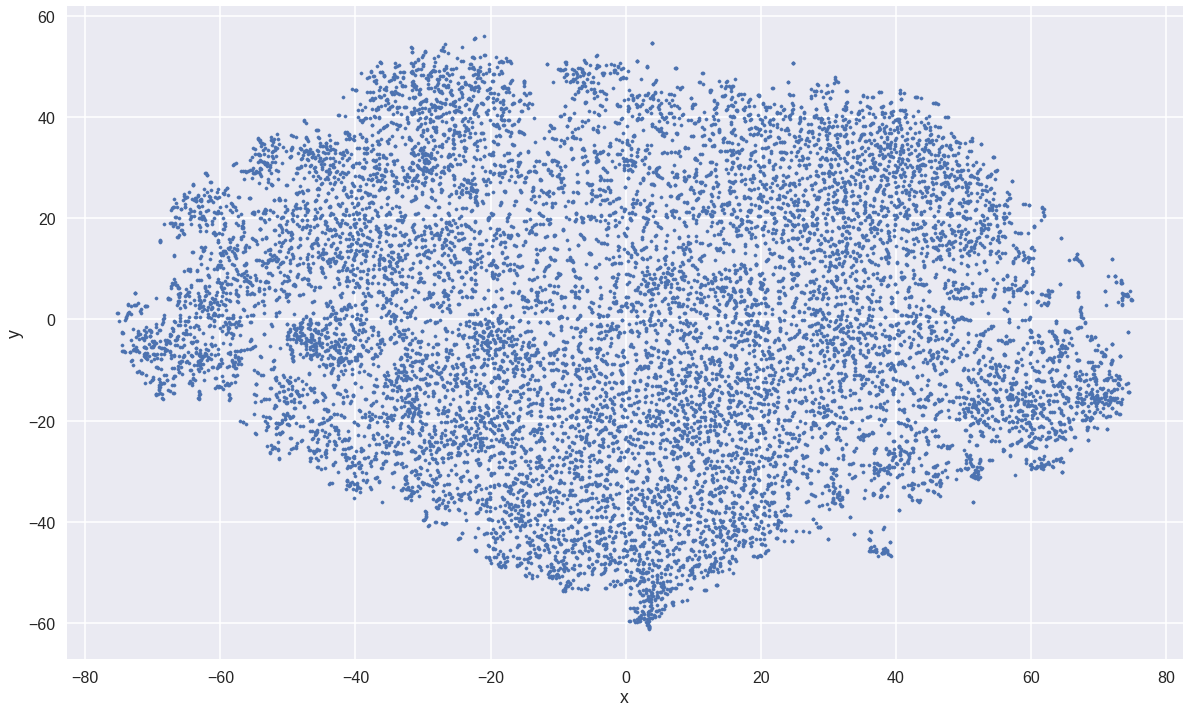

In [67]:
sns.set_context( "poster" )
pts.plot.scatter("x","y" , s = 10 , figsize = (20 , 12))

In [0]:
def plot_region(x_bounds, y_bounds):
    slice = pts[
        (x_bounds[0] <= pts.x) &
        (pts.x <= x_bounds[1]) & 
        (y_bounds[0] <= pts.y) &
        (pts.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

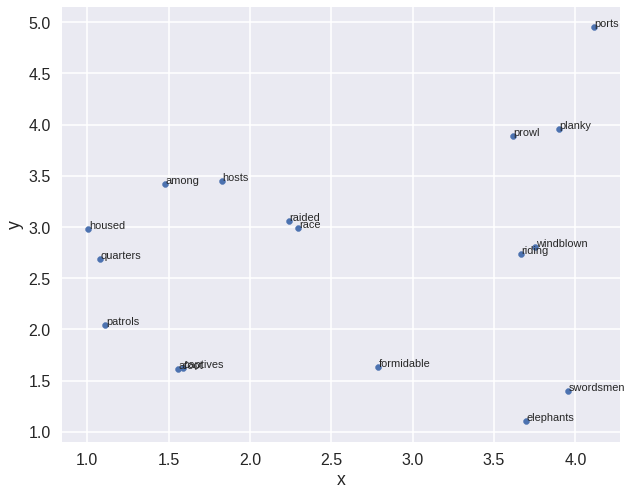

In [83]:
plot_region(x_bounds=(1, 4.2), y_bounds=(1, 5))

In [85]:
thrones2vec.most_similar("stark")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'eddard', 0.7778913974761963),
 (u'winterfell', 0.6975862383842468),
 (u'starks', 0.6908963322639465),
 (u'boltons', 0.6810083389282227),
 (u'executed', 0.6685200929641724),
 (u'beheaded', 0.6659090518951416),
 (u'presumed', 0.6559314727783203),
 (u'hostage', 0.646308183670044),
 (u'trace', 0.6382408142089844),
 (u'lyanna', 0.6376966834068298)]

In [86]:
thrones2vec.most_similar("aerys")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'ii', 0.8180118799209595),
 (u'usurper', 0.8175176978111267),
 (u'jaehaerys', 0.8129401206970215),
 (u'unworthy', 0.7938663363456726),
 (u'reign', 0.7908473014831543),
 (u'poisoned', 0.7885962128639221),
 (u'targaryen', 0.7802832126617432),
 (u'daeron', 0.7774354219436646),
 (u'perished', 0.7742822170257568),
 (u'murdering', 0.7697936296463013)]

In [87]:
thrones2vec.most_similar("snow")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'ghost', 0.7142136096954346),
 (u'stonesnake', 0.6849011182785034),
 (u'ygritte', 0.6576416492462158),
 (u'eagle', 0.6431682109832764),
 (u'garron', 0.6406009197235107),
 (u'ice', 0.6370310187339783),
 (u'falling', 0.6202799081802368),
 (u'rattleshirt', 0.6199225187301636),
 (u'orell', 0.6172577738761902),
 (u'skinchanger', 0.6132029294967651)]

In [88]:
thrones2vec.most_similar("jon")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'ygritte', 0.6214633584022522),
 (u'pyp', 0.6134499311447144),
 (u'ghost', 0.6105702519416809),
 (u'stonesnake', 0.6095149517059326),
 (u'mance', 0.6002695560455322),
 (u'qhorin', 0.5990426540374756),
 (u'sam', 0.5964173078536987),
 (u'orell', 0.5961445569992065),
 (u'samwell', 0.5943598747253418),
 (u'val', 0.5830471515655518)]

In [90]:
thrones2vec.most_similar("tyrion")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'dwarf', 0.7154562473297119),
 (u'bronn', 0.6292260885238647),
 (u'jaime', 0.6081578731536865),
 (u'halfmaester', 0.600853443145752),
 (u'kevan', 0.6007027626037598),
 (u'imp', 0.5972979068756104),
 (u'uncomfortably', 0.5954472422599792),
 (u'quite', 0.5953255891799927),
 (u'shae', 0.5932325124740601),
 (u'cersei', 0.5905725955963135)]

In [0]:
def nearest_similarity_cosmul(start1, end1, end2):
    start1 = start1.lower()
    end1 = end1.lower()
    end2 = end2.lower()
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))

In [104]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")

stark is related to winterfell, as tully is related to riverrun


In [106]:
nearest_similarity_cosmul("Stark", "Winterfell", "King")



stark is related to winterfell, as baratheon is related to king
